In [1]:
#%matplotlib notebook

# import modules
import random
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
from pathlib import Path
import os
cwd = os.getcwd()
#import statsmodels.stats.moment_helpers
#from datetime import datetime
#import multiprocessing as mp
import csv
import networkx as nx
from IPython.display import HTML
from matplotlib import animation
import networkx as nx

# Setup

## Parameters

In [2]:
plotIter=100
nnodes=350
p_link=.1
leak=.25#
leaktype=1 #1 = leak a percentage, or 2 = leak a constant rate
lrate_wmat=.01
lrate_targ=.01
targ_min=1
sens_offset=30
movement_amp=10
input_amp=.75
spike_cost = 0#.01
stim_speed = 1
noise_sd = 0#1
weight_sd_init = 1
effector_type = 1
acts_neg=0

## Set up sensor nodes and input connections

In [3]:
sens_degrees = np.concatenate([np.flip(np.arange(-61,63,4)+30), np.flip(np.arange(-60,64,4)-30)])

input_wmat=np.zeros((len(sens_degrees),nnodes))
for row in range(input_wmat.shape[0]):
    for col in range(nnodes):
        input_wmat[row,col]=random.choices([0,input_amp], weights=(1-p_link,p_link), k=1)[0]

In [4]:
np.flip(np.arange(-61,63,4)+30)

array([ 89,  85,  81,  77,  73,  69,  65,  61,  57,  53,  49,  45,  41,
        37,  33,  29,  25,  21,  17,  13,   9,   5,   1,  -3,  -7, -11,
       -15, -19, -23, -27, -31])

In [5]:
np.flip(np.arange(-60,64,4)-30)

array([ 30,  26,  22,  18,  14,  10,   6,   2,  -2,  -6, -10, -14, -18,
       -22, -26, -30, -34, -38, -42, -46, -50, -54, -58, -62, -66, -70,
       -74, -78, -82, -86, -90])

In [6]:
len(np.flip(np.arange(-60,64,4)-30))

31

## Set up internal weight matrix

In [7]:
link_mat = np.zeros((nnodes,nnodes))
inhibitory_nodes=[]
for row in range(link_mat.shape[0]):
    inhibitory = random.choices([0,1],weights=(.75,.25),k=1)[0]
    if inhibitory == 1:
        inhibitory_nodes.append(row)
    for col in range(link_mat.shape[1]):
        if row == col:
            continue
        if inhibitory == 1:
            link_mat[row,col] = random.choices([0,-1], weights=(1-p_link,p_link), k=1)[0]
        else:
            link_mat[row,col] = random.choices([0,1], weights=(1-p_link,p_link), k=1)[0]
        
wmat=np.zeros((nnodes,nnodes))
for row in range(wmat.shape[0]):
    for col in range(wmat.shape[1]):
        if link_mat[row,col] == 1:
            wmat[row,col] =  np.random.normal(input_amp,.1)
        if link_mat[row,col] == -1:
            wmat[row,col] = np.random.normal(-input_amp,.1)
            
start_wmat=wmat.copy()

In [8]:
# # hist of wmat
# n, bins, patches = plt.hist(x=np.matrix.flatten(wmat[link_mat != 0]), bins='auto', color='#0504aa',
#                             alpha=0.7, rwidth=0.85)
# plt.grid(axis='y', alpha=0.75)
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Weights at Start')
# #plt.text(23, 45, r'$\mu=15, b=3$')
# maxfreq = n.max()
# # Set a clean upper y-axis limit.
# plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [9]:
effector_nodes=[]
output_wmat=np.zeros((nnodes,2))
for row in range(output_wmat.shape[0]):
    for col in range(output_wmat.shape[1]):
        output_wmat[row,col]=random.choices([0,1], weights=(1-p_link,p_link), k=1)[0]
        if output_wmat[row,col] != 0:
            effector_nodes.append(row)

## Functions

In [10]:
def get_plot_vals(degree, heading):
    x = np.cos(np.radians(degree))
    y = np.sin(np.radians(degree))
    
    sLdeg = heading + sens_offset
    if sLdeg > 360:
        sLdeg = sLdeg - 360
    sRdeg = heading - sens_offset
    if sRdeg < 0:
        sRdeg = 360 + sRdeg
        
    sLx = .5*np.cos(np.radians(sLdeg)) 
    sLy = .5*np.sin(np.radians(sLdeg)) 
    sLpos = np.array([sLx,sLy])
    
    sRx = .5*np.cos(np.radians(sRdeg)) 
    sRy = .5*np.sin(np.radians(sRdeg))
    sRpos = np.array([sRx, sRy])
    
    return x, y, sLx, sLy, sRx, sRy

def move_stim(degree, direction):
    if direction == 1:
        degree += stim_speed
    else:
        degree -= stim_speed
        
    if degree > 360:
        degree = degree - 360
    if degree < 0:
        degree = degree + 360

    return degree

def rotate_agent(output_acts, heading):
    diff = (output_acts[0] - output_acts[1])*movement_amp
    heading = heading + diff
    
    if heading > 360:
        heading = heading - 360
    if heading < 0:
        heading = heading + 360
    
    return heading

def get_input_acts(heading, degree):
    
    sens_degrees_ = sens_degrees + heading
    sens_degrees_[sens_degrees_>360]-=360
    sens_degrees_[sens_degrees_<0]+=360
    
    sens_dists = np.abs(sens_degrees_ - degree)
    sens_acts = np.zeros(len(sens_degrees))
    sens_acts[sens_dists<=4]= 1 #- sens_dists/60
        
    return sens_acts

def get_acts(acts,leak,spikes,wmat,input,input_wmat,targets, refractory, refractory_acts,spike_rep):
     
    acts = acts*(1-leak) + np.dot(input, input_wmat) + np.dot(spikes, wmat)

    if acts_neg == 0:
        acts[acts<0]=0
    
    prev_spikes = spikes.copy() 
    thresholds=targets*2
    spikes[acts >= thresholds]=1
    spikes[acts < thresholds]=0
    
    acts[spikes==1]-=thresholds[spikes==1]
       
    errors=acts-targets
    
    return acts, spikes, errors, refractory,refractory_acts, prev_spikes, spike_rep

def learning(learn_on,link_mat,spikes,prev_spikes, errors,wmat,targets):
    
    active_neighbors=np.abs(link_mat.copy())
    active_neighbors[prev_spikes==0,:]=0
    d_wmat = active_neighbors.copy()
    active_neighbors=np.sum(active_neighbors,axis=0)#+np.repeat(1,nnodes)
    
    if learn_on==1:
        if np.sum(active_neighbors) >0:
            d_wmat = errors*d_wmat
            d_wmat=(d_wmat/active_neighbors)
            #d_wmat=(d_wmat/(active_neighbors+1))
            d_wmat=np.nan_to_num(d_wmat)
            wmat-=d_wmat
            
        #targets=targets+((errors/(active_neighbors+1))*lrate_targ)
        targets=targets+(errors*lrate_targ) 
        targets[targets<targ_min]=targ_min
            
    return wmat, targets



# Run the model

/var/folders/4l/vdtt_pdj26z3pnjjrzxryb20kgdqb9/T/ipykernel_39292/2790758162.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spikes_overTime=spikes_overTime.append([spikes],ignore_index=True)
/var/folders/4l/vdtt_pdj26z3pnjjrzxryb20kgdqb9/T/ipykernel_39292/2790758162.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acts_overTime=acts_overTime.append([acts],ignore_index=True)
/var/folders/4l/vdtt_pdj26z3pnjjrzxryb20kgdqb9/T/ipykernel_39292/2790758162.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  positionData=positionData.append([[degree, heading, 0]],ignore_index=True)


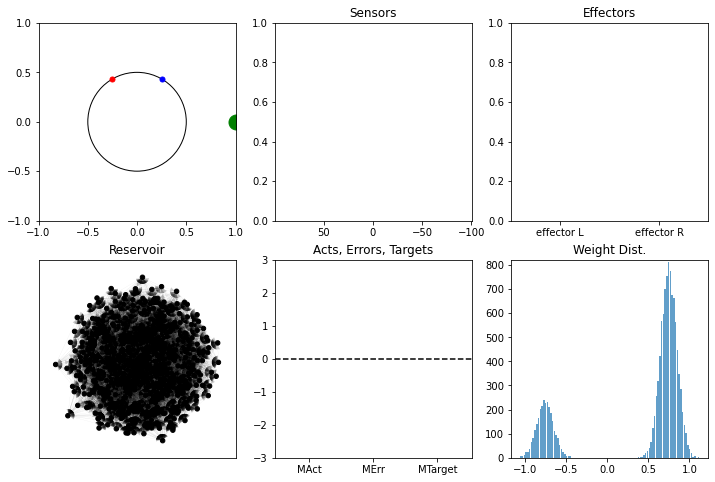

In [11]:
spikes=np.zeros(nnodes)
spike_rep=np.zeros(nnodes)
refractory=np.zeros(nnodes)
refractory_acts=np.zeros(nnodes)
targets=np.repeat(targ_min,nnodes)
acts=np.zeros(nnodes)
inputs = np.zeros(len(sens_degrees))
output_acts = np.zeros(2)
# output_spikes = np.zeros(2)
# output_targets = np.repeat(targ_min,2)
MeanErs=[]
MeanActs =[]
MeanSpikes=[]
spikes_overTime=pd.DataFrame()
spikes_overTime=spikes_overTime.append([spikes],ignore_index=True)
acts_overTime = pd.DataFrame()
acts_overTime=acts_overTime.append([acts],ignore_index=True)


i=1
degree = 0
heading = 90
direction = 1

positionData=pd.DataFrame()
positionData=positionData.append([[degree, heading, 0]],ignore_index=True)

learn_on=1
def drawframe(n):
    global acts_overTime, spikes_overTime, positionData,layout,refractory,refractory_acts,noise_sd,link_decay,spike_rep,direction,degree, heading, acts, input_acts, output_acts, leak, spikes, prev_spikes, wmat, input_wmat, output_wmat, targets, errors,MeanAbsErs,MeanActs,MeanSpikes
    
    print(n)
    #     if n==(plotIter/2):
    if (n %  720 == 0) and (n !=0):
        if direction == 1:
            direction = 2
        else:
            direction = 1
    
    if n > 50:
        input = np.zeros(len(sens_degrees))
    else:
        input = get_input_acts(heading, degree)
    
    acts, spikes, errors, refractory,refractory_acts, prev_spikes, spike_rep = get_acts(acts,leak,spikes,wmat,input,input_wmat,targets,refractory,refractory_acts,spike_rep)
    spikes_overTime=spikes_overTime.append([spikes],ignore_index=True)
    acts_overTime=acts_overTime.append([acts],ignore_index=True)
    
    output_acts = np.dot(spikes, output_wmat)/np.sum(output_wmat, axis=0)
        
    wmat, targets = learning(learn_on,link_mat,spikes,prev_spikes, errors, wmat,targets)
    
    x, y, sLx, sLy, sRx, sRy = get_plot_vals(degree, heading)
    
    degree = move_stim(degree, direction)
    heading = rotate_agent(output_acts, heading)
    positionData=positionData.append([[degree, heading, n]],ignore_index=True)

    pt1.set_data(x,y)
    sL.set_data(sLx,sLy)
    sR.set_data(sRx,sRy)

    ax2.clear()
    ax2.set_ylim((0, 1))
    ax2.bar(sens_degrees,input, color = bar_colors, width=3,alpha=.4)
    ax2.invert_xaxis()

    bar1_plt3.set_height(output_acts[0])
    bar2_plt3.set_height(output_acts[1])
    
    ax4.clear()
    nx.draw_networkx(net, arrows=True,width=.1,with_labels=False, node_size=20, pos = layout, edge_color=edge_colors,node_color=spikes)
    
    bar1_plt5.set_height(np.mean(acts))
    bar2_plt5.set_height(np.mean(errors[refractory!=2]))
    bar3_plt5.set_height(np.mean(targets))
    
    ax6.clear()
    f, bins, patches = ax6.hist(x=np.matrix.flatten(wmat[link_mat!=0]), bins='auto',alpha=0.7, rwidth=0.85)
    maxfreq = f.max()
    ax6.set_ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

    txt_title1.set_text('Frame = {0:4d}'.format(n))
    txt_title2 = ax2.set_title('Sensors')
    txt_title4 = ax4.set_title('Reservoir')
    txt_title6 = ax6.set_title('Weight Dist.')
    
    if (n % 100 !=0):
        MeanEr = np.mean(errors[refractory!=2])
        MeanErs.append(MeanEr)
        MeanAct = np.mean(acts)
        MeanActs.append(MeanAct)
        MeanSpike = np.mean(spikes)
        MeanSpikes.append(MeanSpike)
        #print('iteration: ', n, ' ; MeanAbsEr: ',MeanAbsEr, ' ; MeanAct: ', MeanAct)
    else:
        MeanEr = np.mean(errors[refractory!=2])
        MeanErs.append(MeanEr)
        MeanAct = np.mean(acts)
        MeanActs.append(MeanAct)
        MeanSpike = np.mean(spikes)
        MeanSpikes.append(MeanSpike)
        
        MeanErs_ = np.round(np.mean(MeanErs),decimals=2)
        MeanActs_ = np.round(np.mean(MeanActs),decimals=2)
        MeanSpikes_ = np.round(np.mean(MeanSpikes),decimals=2)
        print('iteration: ', str(n), ' ; MeanErs: ',str(MeanErs_), ' ; MeanAct: ', str(MeanActs_), '; MeanSpikes: ', str(MeanSpikes_))
        MeanAbsErs=[]
        MeanActs=[]
        MeanSpikes=[]       

    return (pt1,sL,sR)

# create a figure and axes
fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,4)
ax5 = plt.subplot(2,3,5)
ax6 = plt.subplot(2,3,6)

ax1.set_xlim(( -1, 1))            
ax1.set_ylim((-1, 1))
ax1.set_yticks((-1,-.5,0,.5,1))
circle1 = plt.Circle((0, 0), 0.5, color='black', fill = 0)
ax1.add_patch(circle1)
pt1, = ax1.plot([], [], 'g.', ms=30)
sL, = ax1.plot([],[], 'r.', ms =10)
sR, = ax1.plot([],[], 'b.', ms =10)
x, y, sLx, sLy, sRx, sRy = get_plot_vals(degree,heading)
pt1.set_data(x,y)
sL.set_data(sLx,sLy)
sR.set_data(sRx,sRy)

ax2.set_ylim((0, 1))
bar_colors=np.array(np.repeat(['r','b'],31))
plt2 = ax2.bar(sens_degrees,inputs, color = bar_colors, width=3,alpha=.4)
ax2.invert_xaxis()

ax3.set_ylim((0, 1))
bar1_plt3, bar2_plt3 = ax3.bar(['effector L', 'effector R'],[0,0], color = ['r','b'])

plt.sca(ax4)
net = nx.from_numpy_matrix(np.abs(link_mat))
layout = nx.spring_layout(net)
edge_colors=np.repeat([[0.0,0.0,0.0,.2]],len(net.edges),axis=0)
node_colors=np.repeat([[0.0,0.0,0.0,1]],nnodes,axis=0)
netfig  = nx.draw_networkx(net, arrows=True,width=.1,with_labels=False, node_size=20, pos = layout, edge_color=edge_colors,node_color=node_colors)

ax5.set_ylim(-3,3)
bar1_plt5, bar2_plt5, bar3_plt5 = ax5.bar(['MAct','MErr', 'MTarget'],[0,0,0],color = 'black')
ax5.axhline(y=0.0, color='black', linestyle='--')

f, bins, patches = ax6.hist(x=np.matrix.flatten(wmat[link_mat!=0]), bins='auto',alpha=0.7, rwidth=0.85)
maxfreq = f.max()
ax6.set_ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

txt_title1 = ax1.set_title('')
txt_title2 = ax2.set_title('Sensors')
txt_title3 = ax3.set_title('Effectors')
txt_title4 = ax4.set_title('Reservoir')
txt_title5 = ax5.set_title('Acts, Errors, Targets')
txt_title6 = ax6.set_title('Weight Dist.')


In [14]:
#anim = animation.FuncAnimation(fig, drawframe, frames=plotIter, interval=20, blit=True)
#plt.show()
#anim.save('MV_RotatingAgent3_unitTest.mp4') #v1
spikes_overTime.to_csv('spikes_overTime_Rotating_unitTest.csv')
acts_overTime.to_csv('acts_overTime_Rotating_unitTest.csv')

positionData.to_csv('positionData_Rotating_unitTest.csv')